In [1]:
from pathlib import Path
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

DATA_PATH = Path("agent_pr_allcomments_with_loc.csv")

# Load data
raw_df = pd.read_csv(DATA_PATH)
raw_df["Total_LOC_Change"] = pd.to_numeric(raw_df["Total_LOC_Change"], errors="coerce")
raw_df = raw_df.dropna(subset=["Total_LOC_Change"]).copy()
raw_df["Total_LOC_Change"] = raw_df["Total_LOC_Change"].astype(int)

# Handle missing task types
raw_df["Task_Type"] = raw_df["Task_Type"].fillna("unknown")

print(f"Total rows loaded: {len(raw_df):,}")
print(f"Unique agents: {raw_df['Agent'].nunique()}")
print(f"Unique task types: {raw_df['Task_Type'].nunique()}")
print(f"\nTask types found: {sorted(raw_df['Task_Type'].unique())}")
raw_df.head()

Total rows loaded: 87,463
Unique agents: 5
Unique task types: 13

Task types found: ['build', 'chore', 'ci', 'docs', 'feat', 'fix', 'other', 'perf', 'refactor', 'revert', 'style', 'test', 'unknown']


,Agent,PR_ID,Task_Type,Total_LOC_Change,Additions,Deletions,Comment_Category,Comment_Body,User_Login,User_Type
0,Devin,2768448959,feat,99,96,3,PR_Comment,### 🤖 Devin AI Engineer\n\nI'll be helping wit...,devin-ai-integration[bot],Bot
1,Devin,3058782123,feat,872,574,298,PR_Comment,### 🤖 Devin AI Engineer\n\nI'll be helping wit...,devin-ai-integration[bot],Bot
2,Devin,2975299996,feat,267,260,7,PR_Comment,### 🤖 Devin AI Engineer\n\nI'll be helping wit...,devin-ai-integration[bot],Bot
3,Devin,2844229241,refactor,6946,6659,287,PR_Comment,### 🤖 Devin AI Engineer\n\nI'll be helping wit...,devin-ai-integration[bot],Bot
4,Devin,2844229241,refactor,6946,6659,287,PR_Comment,[vc]: #+9eW4f+eRTWvUsAhdH/Hiu2kgZ4CCAmLuKRq27r...,vercel[bot],Bot


In [2]:
# Create unique agent-PR-task combinations for LOC analysis
core_columns = ["Agent", "PR_ID", "Task_Type", "Total_LOC_Change"]
agent_task_loc = raw_df.loc[:, core_columns].drop_duplicates()

print(f"Unique (Agent, PR_ID, Task_Type) combinations: {len(agent_task_loc):,}")

# Define preferred agent order
preferred_agent_order = ["OpenAI_Codex", "Cursor", "Claude_Code", "Copilot", "Devin"]
available_agents = agent_task_loc["Agent"].dropna().unique().tolist()

agents_of_interest = []
for agent in preferred_agent_order:
    if agent in available_agents and agent not in agents_of_interest:
        agents_of_interest.append(agent)

agents_of_interest.extend(
    sorted(agent for agent in available_agents if agent not in agents_of_interest)
)

print(f"\nAgents analyzed: {', '.join(agents_of_interest)}")

# Get task type distribution per agent
task_dist = agent_task_loc.groupby(["Agent", "Task_Type"]).size().reset_index(name="PR_Count")
task_pivot = task_dist.pivot(index="Agent", columns="Task_Type", values="PR_Count").fillna(0).astype(int)
task_pivot = task_pivot.reindex(agents_of_interest)
print("\nPR count by Agent and Task Type:")
task_pivot

Unique (Agent, PR_ID, Task_Type) combinations: 30,553

Agents analyzed: OpenAI_Codex, Cursor, Claude_Code, Copilot, Devin

PR count by Agent and Task Type:


Task_Type,build,chore,ci,docs,feat,fix,other,perf,refactor,revert,style,test,unknown
Agent,,,,,,,,,,,,,
OpenAI_Codex,64,172,48,408,1704,1422,5,37,384,2,27,265,1184
Cursor,28,44,15,171,480,329,6,15,88,0,18,21,502
Claude_Code,3,8,0,22,184,79,0,1,16,0,0,4,294
Copilot,92,74,54,377,1264,1535,5,35,244,4,10,130,11103
Devin,63,280,59,619,1899,1244,3,62,436,6,25,116,2764


## RQ2: Correlation Between LOC Changes and Comment Count

**Research Question:** Does the amount of discussion (comment count) correlate with the size of code changes (LOC)?

### PR-Level Analysis
For each agent-task combination, we test whether individual PRs with more comments also have larger LOC changes.

**Variables:**
- Independent: Total Comments (count of user + bot comments)
- Dependent: Total LOC Change (lines added + deleted)

In [3]:
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("RQ2: PR-LEVEL CORRELATION ANALYSIS")
print("="*80)
print("\nTesting correlation between LOC changes and comment count")
print("for each agent-task combination\n")

# Merge LOC and comments data at PR level
# First, create comment matrix
comment_counts = (
    raw_df.groupby(["Agent", "PR_ID", "Task_Type", "User_Type"], dropna=False)
    .size()
    .reset_index(name="Comment_Count")
)

agent_task_comment_matrix = (
    comment_counts.pivot_table(
        index=["Agent", "PR_ID", "Task_Type"],
        columns="User_Type",
        values="Comment_Count",
        fill_value=0,
        aggfunc="sum",
    )
    .rename_axis(None, axis=1)
    .reset_index()
)

for col in ["Bot", "User"]:
    if col not in agent_task_comment_matrix.columns:
        agent_task_comment_matrix[col] = 0

agent_task_comment_matrix = agent_task_comment_matrix.rename(
    columns={"Bot": "Bot_Comments", "User": "User_Comments"}
)
agent_task_comment_matrix["Total_Comments"] = (
    agent_task_comment_matrix["Bot_Comments"] + agent_task_comment_matrix["User_Comments"]
)

# Merge with LOC data
pr_task_metrics = (
    agent_task_loc[["Agent", "PR_ID", "Task_Type", "Total_LOC_Change"]]
    .merge(
        agent_task_comment_matrix[["Agent", "PR_ID", "Task_Type", "Total_Comments"]],
        on=["Agent", "PR_ID", "Task_Type"],
        how="inner",
    )
    .dropna(subset=["Total_LOC_Change", "Total_Comments"])
)

print(f"Total PRs with both LOC and comment data: {len(pr_task_metrics):,}\n")

rq2_correlation_results = []

for (agent, task_type), data in pr_task_metrics.groupby(["Agent", "Task_Type"]):
    n = len(data)
    if n < 3:
        continue
    
    # Use Spearman correlation (non-parametric, no normality assumptions)
    corr_coef, p_value = spearmanr(data['Total_LOC_Change'], data['Total_Comments'])
    
    # Effect size categorization
    abs_corr = abs(corr_coef)
    if abs_corr < 0.1:
        effect_size = "negligible"
    elif abs_corr < 0.3:
        effect_size = "small"
    elif abs_corr < 0.5:
        effect_size = "moderate"
    else:
        effect_size = "large"
    
    # Summary statistics
    mean_loc = data['Total_LOC_Change'].mean()
    median_loc = data['Total_LOC_Change'].median()
    mean_comments = data['Total_Comments'].mean()
    median_comments = data['Total_Comments'].median()
    
    rq2_correlation_results.append({
        'agent': agent,
        'task_type': task_type,
        'n_prs': n,
        'mean_loc': mean_loc,
        'median_loc': median_loc,
        'mean_comments': mean_comments,
        'median_comments': median_comments,
        'correlation_coefficient': corr_coef,
        'p_value': p_value,
        'effect_size_category': effect_size,
        'abs_correlation': abs_corr
    })

# Create results DataFrame
rq2_correlation_df = pd.DataFrame(rq2_correlation_results)

print(f"Analyzed {len(rq2_correlation_df)} agent-task combinations\n")
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total combinations analyzed: {len(rq2_correlation_df)}")
print(f"Positive correlations: {(rq2_correlation_df['correlation_coefficient'] > 0).sum()}")
print(f"Negative correlations: {(rq2_correlation_df['correlation_coefficient'] < 0).sum()}")
print(f"Average |correlation|: {rq2_correlation_df['abs_correlation'].mean():.3f}")
print(f"\nEffect sizes:")
print(rq2_correlation_df['effect_size_category'].value_counts())

display(rq2_correlation_df)

RQ2: PR-LEVEL CORRELATION ANALYSIS

Testing correlation between LOC changes and comment count
for each agent-task combination

Total PRs with both LOC and comment data: 30,553

Analyzed 58 agent-task combinations

SUMMARY STATISTICS
Total combinations analyzed: 58
Positive correlations: 48
Negative correlations: 6
Average |correlation|: 0.258

Effect sizes:
effect_size_category
small         27
moderate      12
negligible    10
large          9
Name: count, dtype: int64


,agent,task_type,n_prs,mean_loc,median_loc,mean_comments,median_comments,correlation_coefficient,p_value,effect_size_category,abs_correlation
0,Claude_Code,build,3,214921.333333,1249.0,1.333333,1.0,0.866025,3.333333e-01,large,0.866025
1,Claude_Code,chore,8,10582.125000,1055.0,5.250000,6.0,0.365963,3.726247e-01,moderate,0.365963
2,Claude_Code,docs,22,5114.000000,326.0,2.772727,1.5,0.061640,7.852378e-01,negligible,0.061640
3,Claude_Code,feat,184,11546.054348,2152.0,5.103261,3.0,0.115030,1.199752e-01,small,0.115030
4,Claude_Code,fix,79,7648.911392,204.0,4.481013,3.0,0.210276,6.288052e-02,small,0.210276
5,Claude_Code,refactor,16,1200.687500,322.5,4.562500,3.5,0.293397,2.700771e-01,small,0.293397
6,Claude_Code,test,4,1289.000000,615.5,5.500000,3.0,-0.316228,6.837722e-01,moderate,0.316228
7,Claude_Code,unknown,294,0.000000,0.0,1.295918,1.0,NaN,NaN,large,NaN
8,Copilot,build,92,22996.891304,108.0,8.347826,5.0,0.399266,8.062358e-05,moderate,0.399266
9,Copilot,chore,74,17126.189189,244.0,7.351351,6.0,0.313147,6.595127e-03,moderate,0.313147


## Detailed Results by Agent

In [4]:
# Detailed Results by Agent
print("="*80)
print("DETAILED RESULTS BY AGENT")
print("="*80)

for agent in sorted(rq2_correlation_df['agent'].unique()):
    agent_data = rq2_correlation_df[rq2_correlation_df['agent'] == agent].sort_values('abs_correlation', ascending=False)
    
    print(f"\n{agent}:")
    print("-" * 60)
    print(f"  Task types analyzed: {len(agent_data)}")
    print(f"  Average |r|: {agent_data['abs_correlation'].mean():.3f}")
    
    # Show top correlations
    print(f"\n  Top correlations by strength:")
    for _, row in agent_data.head(5).iterrows():
        direction = "+" if row['correlation_coefficient'] > 0 else "-"
        print(f"    • {row['task_type']:12s}: r={row['correlation_coefficient']:+.3f} (p={row['p_value']:.4f}) | n={int(row['n_prs']):4d} PRs | {row['effect_size_category']}")

DETAILED RESULTS BY AGENT

Claude_Code:
------------------------------------------------------------
  Task types analyzed: 8
  Average |r|: 0.318

  Top correlations by strength:
    • build       : r=+0.866 (p=0.3333) | n=   3 PRs | large
    • chore       : r=+0.366 (p=0.3726) | n=   8 PRs | moderate
    • test        : r=-0.316 (p=0.6838) | n=   4 PRs | moderate
    • refactor    : r=+0.293 (p=0.2701) | n=  16 PRs | small
    • fix         : r=+0.210 (p=0.0629) | n=  79 PRs | small

Copilot:
------------------------------------------------------------
  Task types analyzed: 13
  Average |r|: 0.449

  Top correlations by strength:
    • style       : r=+0.954 (p=0.0000) | n=  10 PRs | large
    • revert      : r=+0.632 (p=0.3675) | n=   4 PRs | large
    • test        : r=+0.517 (p=0.0000) | n= 130 PRs | large
    • ci          : r=+0.498 (p=0.0001) | n=  54 PRs | moderate
    • fix         : r=+0.405 (p=0.0000) | n=1535 PRs | moderate

Cursor:
--------------------------------------

## Visualizations

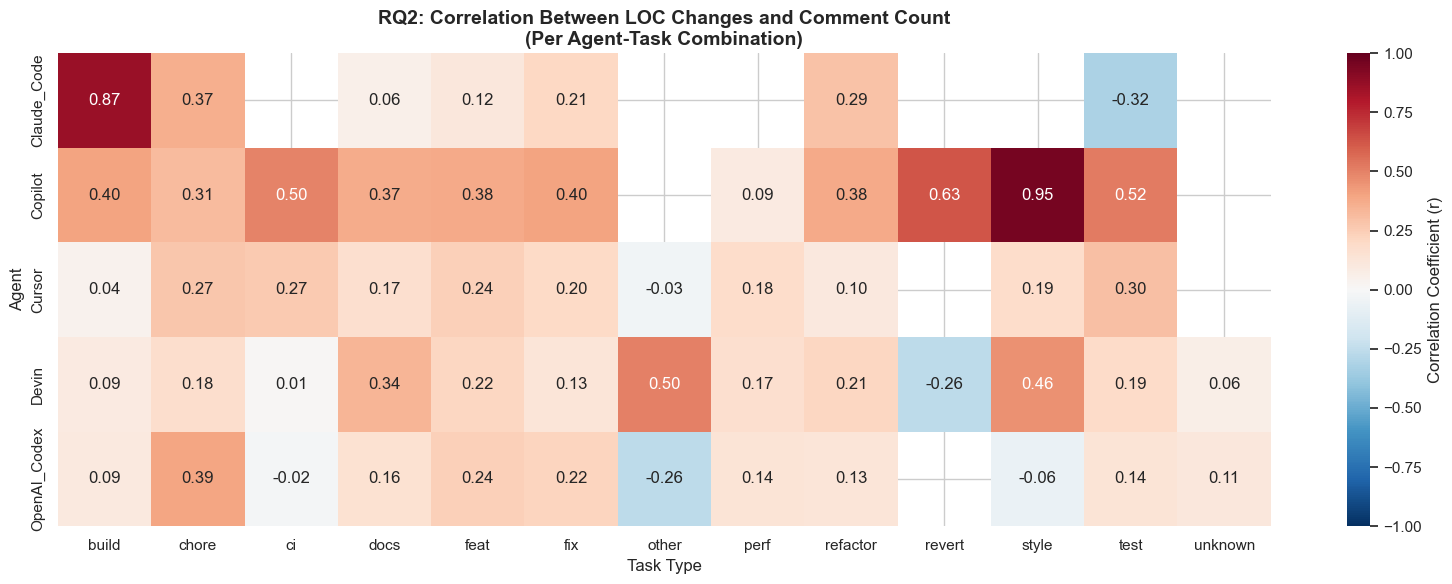

[INFO] Heatmap shows correlation coefficients. Red = negative, Blue = positive


In [5]:
# Visualization 1: Correlation Heatmap
# Create pivot for correlation coefficients
pivot_corr = rq2_correlation_df.pivot(index='agent', columns='task_type', values='correlation_coefficient')

plt.figure(figsize=(16, 6))
ax = sns.heatmap(pivot_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1.0, vmax=1.0, cbar_kws={'label': 'Correlation Coefficient (r)'})

plt.title('RQ2: Correlation Between LOC Changes and Comment Count\n(Per Agent-Task Combination)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Task Type', fontsize=12)
plt.ylabel('Agent', fontsize=12)
plt.tight_layout()
plt.show()

print("[INFO] Heatmap shows correlation coefficients. Red = negative, Blue = positive")

## Export Results

In [6]:
# Export Results to CSV Files
from pathlib import Path

# Export detailed correlation results
correlation_output = Path("rq2_correlation_results.csv")
rq2_correlation_df.to_csv(correlation_output, index=False)
print(f"[SAVED] PR-level correlation analysis results → {correlation_output}")

# Export summary by agent
agent_summary = rq2_correlation_df.groupby('agent').agg({
    'task_type': 'count',
    'correlation_coefficient': ['mean', 'median'],
    'abs_correlation': 'mean',
    'n_prs': 'sum'
}).round(3)
agent_summary.columns = ['n_task_types', 'mean_corr', 'median_corr', 'mean_abs_corr', 'total_prs']

agent_summary_output = Path("rq2_agent_summary.csv")
agent_summary.to_csv(agent_summary_output)
print(f"[SAVED] Agent summary statistics → {agent_summary_output}")

# Display summary
print("\n" + "="*80)
print("AGENT SUMMARY")
print("="*80)
display(agent_summary)

[SAVED] PR-level correlation analysis results → rq2_correlation_results.csv
[SAVED] Agent summary statistics → rq2_agent_summary.csv

AGENT SUMMARY


,n_task_types,mean_corr,median_corr,mean_abs_corr,total_prs
agent,,,,,
Claude_Code,8,0.228,0.210,0.318,610
Copilot,13,0.449,0.399,0.449,14927
Cursor,12,0.175,0.185,0.182,1717
Devin,13,0.176,0.177,0.217,7576
OpenAI_Codex,12,0.106,0.134,0.164,5720
